In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import numpy as np
from math import sqrt

In [2]:
air = pd.read_csv('rsqa-indice-qualite-air-2022-2024.csv')

#Write datetime column
air['heure'] = air['heure'].astype(str).str.zfill(2)
air['corDate'] = air['date'].astype(str) + ' ' + air['heure'].astype(str)
air['DateTime'] = pd.to_datetime(air['corDate'], format='%Y-%m-%d %H')
air = air.drop(['date','heure','corDate'], axis=1)
air.sort_values(by='DateTime', inplace = True)
air = air.set_index('DateTime')


#Select PM pollutant and station to investigate
PM = air[air['polluant'] == 'PM']
PM3 = PM[PM['stationId'] == 3]

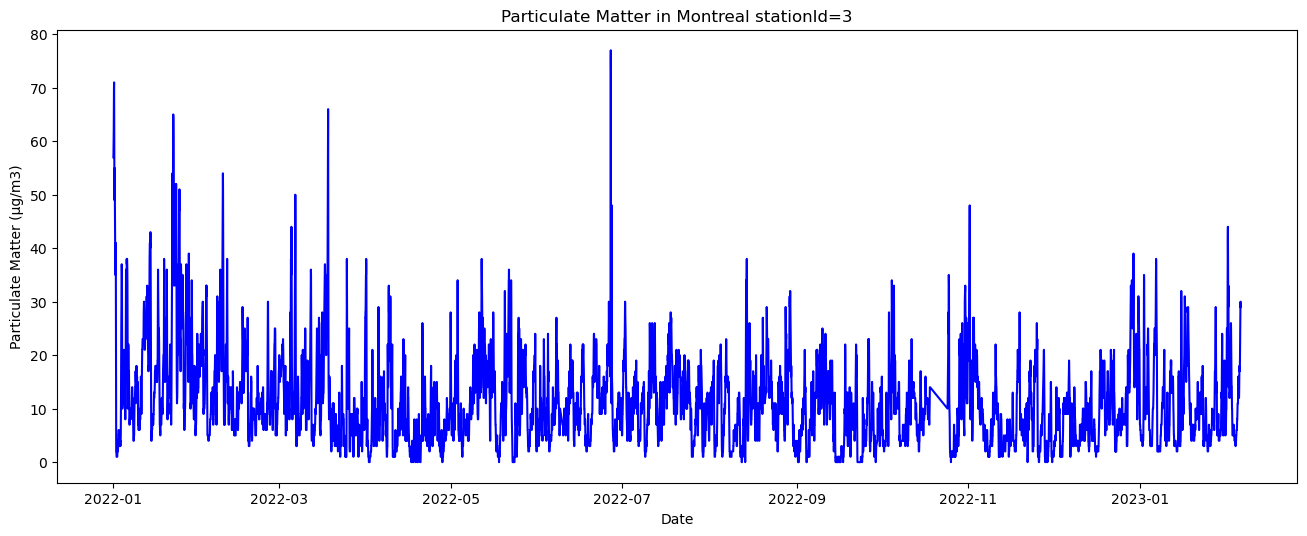

In [3]:
#Plot
def plot_df(df, x, y, title='', xlabel='Date', ylabel='Particulate Matter (µg/m3)', dpi=100, col=''):
    plt.figure(figsize=(16,6), dpi=100)
    plt.plot(x, y, color=col)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(PM3, x = PM3.index, y = PM3.valeur, title = 'Particulate Matter in Montreal stationId=3', col = 'blue')

In [4]:
#Difference transform of the dataset
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
    return np.array(diff)

# Make a prediction give regression coefficients and lag obs
def predict(coef, history):
    yhat = coef[0]
    for i in range(1, len(coef)):
        yhat += coef[i] * history[-i]
    return yhat

In [5]:
#Splitting data 
X = difference(PM3.valeur)
size = int(len(X) * 0.99)

X_train, X_test = X[0:size], X[size:]

In [6]:
#Train autoregression
window = 6
model = AutoReg(X_train, lags=6)
model_fit = model.fit()
coef = model_fit.params

Test RMSE: 1.048


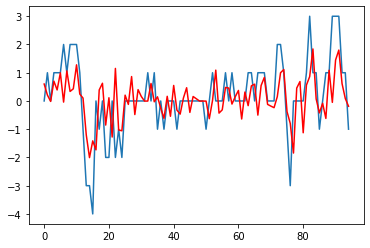

In [7]:
#Walk forward over time steps in test
history = [X_train[i] for i in range(len(X_train))]
predictions = list()
for t in range(len(X_test)):
    yhat = predict(coef, history)
    obs = X_test[t]
    predictions.append(yhat)
    history.append(obs)
rmse = sqrt(mean_squared_error(X_test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
plt.plot(X_test)
plt.plot(predictions, color='red')
plt.show()

In [8]:
#Save model to file
model_fit.save('ar_model.pkl')
#Save the differenced dataset
np.save('ar_data.npy', X)
#Save the last ob
np.save('ar_obs.npy', [PM3.valeur[-1]])